In [39]:
import numpy as np
import pandas as pd
import os
from scipy.stats import zscore
from matplotlib import cm
import matplotlib.pyplot as plt
from PIL import Image, ImageSequence
import png

In [40]:
%matplotlib inline

In [41]:
# from stytra
def calcium_kernel(tau):
    return lambda x: np.exp(-x/(tau/np.log(2)))


def convolve_regressors(regressor, kernel):
    """ Convolves the regressor with a kernel function
    :param regressor: the regressor, or regressor matrix
    :param kernel:
    :return: the convolved kernel
    """
    return np.convolve(regressor, kernel)[0:len(regressor)]


def matplot2plotly_cmap(cmap_type, nsamp=200):
    x = (np.linspace(0, 1, nsamp))
    color_mat = (cm.get_cmap(cmap_type)(x)*255).astype(np.uint8)[:,:3]
    return [[v, "rgb{}".format(tuple(c))] for v, c in zip(x, color_mat)]


def nandot(X, Y):
    return np.nansum(X*Y)


def pearson_coef_pixel(pixel, regressor):
    X = pixel_traces[pixel]
    Y = regressor
    # if regressor is shorter, reduce the size of the pixel trace
    if X.shape != Y.shape:
        Y_bis = np.zeros(X.shape)
        Y_bis[0:len(Y)] = Y
        Y = Y_bis
    numerator = nandot(X, Y) - X.shape[0] * np.nanmean(X) * np.nanmean(Y)
    denominator = (X.shape[0] - 1) * np.nanstd(X) * np.nanstd(Y)
    pearson_corr = numerator/denominator
    return pearson_corr


def load_suite2p_outputs(file_name, input_path):
    """Load every output that the suite2p gives you
    Arguments given are fishlabel, real_trial_num and folder_path.
    If folder_path is not given, automatically check for the data path in the summary csv file.
    You can change the path to the summary csv file here in the function.
    If folder_path is given;
    Returns F, Fneu, spks, stat, ops, iscell"""
    if not os.path.exists(input_path):
        raise FileNotFoundError('Path to your folder is not valid.')
    try:
            F = np.load(input_path + file_name + '/suite2p/plane0' + '/F.npy', allow_pickle=True)
            Fneu = np.load(input_path + file_name + '/suite2p/plane0' + '/Fneu.npy', allow_pickle=True)
            spks = np.load(input_path + file_name + '/suite2p/plane0' + '/spks.npy', allow_pickle=True)
            stat = np.load(input_path + file_name + '/suite2p/plane0' + '/stat.npy', allow_pickle=True)
            ops = np.load(input_path + file_name + '/suite2p/plane0' + '/ops.npy', allow_pickle=True)
            ops = ops.item()
            iscell = np.load(input_path + file_name + '/suite2p/plane0' + '/iscell.npy', allow_pickle=True)
    except FileNotFoundError:
        F = np.load(input_path + file_name + '/F.npy', allow_pickle=True)
        Fneu = np.load(input_path + file_name + '/Fneu.npy', allow_pickle=True)
        spks = np.load(input_path + file_name + '/spks.npy', allow_pickle=True)
        stat = np.load(input_path + file_name + '/stat.npy', allow_pickle=True)
        ops = np.load(input_path + file_name + '/ops.npy', allow_pickle=True)
        ops = ops.item()
        iscell = np.load(input_path + file_name + '/iscell.npy', allow_pickle=True)
    return F, Fneu, spks, stat, ops, iscell

In [42]:
frame_rate_2p = 4.2
# ker is the shape of the calcium transient: it's the negative exponential with b = 1/tau, from 0 to 3sec
# and is shaped with time steps of 1/frame_rate_2p
ker = calcium_kernel(1.5)(np.arange(0,3,1/frame_rate_2p))
ker_zeros = np.zeros((int(2*frame_rate_2p)))
ker2 = np.concatenate((ker_zeros, ker, ker_zeros))

In [43]:
data_path = '/network/lustre/iss01/wyart/analyses/2pehaviour/ML_pipeline_output/dataset/'
fishlabel = '190104_F2'
plane = '6'

suite2p_path = '/network/lustre/iss01/wyart/analyses/2pehaviour/suite2p_output/'
output_path = '/network/lustre/iss01/wyart/analyses/2pehaviour/ML_pipeline_output/'

df_frame = pd.read_pickle(data_path + fishlabel + '_ERC/' + fishlabel + '_analyzed_frame_dataset_' + plane)
df_bouts = pd.read_pickle(data_path + fishlabel + '_ERC/' + fishlabel + '_analyzed_bout_dataset_' + plane)
TA_all = np.array(df_frame.Tail_angle)

F, Fneu, spks, stat, ops, iscell = load_suite2p_outputs(plane, suite2p_path+'/'+fishlabel+'/')

In [26]:
left_ta = np.zeros(TA_all.shape)
right_ta = np.zeros(TA_all.shape)
for bout in df_bouts.index:
    start = df_bouts.BoutStartVideo[bout]
    end = df_bouts.BoutEndVideo[bout]
    if df_bouts.Max_Bend_Amp[bout] < 0:
            right_ta[start:end] = TA_all[start:end]
    else:
        left_ta[start: end] = TA_all[start:end]
        
ta = pd.DataFrame(TA_all, index=pd.date_range(start = "00:00", periods=len(TA_all[:]), freq="0.005S"))
df_left = pd.DataFrame(left_ta, index=pd.date_range(start = "00:00", periods=len(TA_all[:]), freq="0.005S"))
df_right = pd.DataFrame(right_ta, index=pd.date_range(start = "00:00", periods=len(TA_all[:]), freq="0.005S"))

ta_downsample = ta.resample("0.238S").sum()
left_downsample = df_left.resample("0.238S").sum()
right_downsample = df_right.resample("0.238S").sum()

vigor_regressor = abs(np.array(ta_downsample).flatten())
left_regressor = abs(np.array(left_downsample).flatten())
right_regressor = abs(np.array(right_downsample).flatten())

# Then the final step is to convolve these regressors with the kernel shape we built (the calcium decay shape)

# first we convolve (we get really high values since convolving is a kind of multiplication)
convolved = convolve_regressors(vigor_regressor, ker)
# then we calculate the zscore (a way to normalize the value to the mean and the std of the regressor)
final_all_reg = zscore(convolved)
final_left_reg = zscore(convolve_regressors(left_regressor, ker))
final_right_reg = zscore(convolve_regressors(right_regressor, ker))

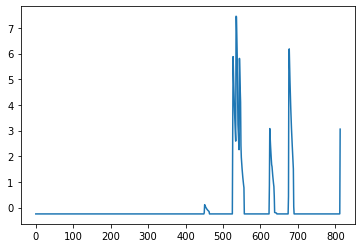

In [27]:
vigor_regressor = final_left_reg+final_right_reg
plt.plot(final_right_reg)

In [28]:
# trying to do cmap with pixel traces, and not the DF/F

# loading the tif image
im = Image.open('/home/mathilde.lapoix/Documents/RSN_project/Data/2P/' + fishlabel + '/' + plane + '/registered_stack_plane' + plane + '.tif')

# converting the tiff image in array
imarray = np.array(im)
nFrames = 846
# the tiff array will be in 3D: 2D of number of pixels, and the third D is the time.
tiff_array = np.zeros((imarray.shape[0], imarray.shape[1], nFrames))

In [29]:
# get each frame of the tif file to be concatenated to the array
for i, frame in enumerate(ImageSequence.Iterator(im)):
    tiff_array[:,:,i] = frame
    
# remove frames with movement
# frames_mov = np.where(np.isnan(F_corrected[0]))[0]
# tiff_array[:,:, frames_mov] = np.nan

# calculate the zscore of each trace, and reshape the array to lines as pixel number, and cols as time
pixel_traces = zscore(tiff_array.reshape((-1, tiff_array.shape[2])))

In [30]:
pixels = range(pixel_traces.shape[0])
cmap_left_pixel = pd.Series(pixels).apply(pearson_coef_pixel, args=(final_left_reg,))
cmap_right_pixel = pd.Series(pixels).apply(pearson_coef_pixel, args=(final_right_reg,))
# cmap_vigor_pixel = pd.Series(pixels).apply(pearson_coef_pixel, args=(final_all_reg,))

In [31]:
cmap_vigor_pixel = pd.Series(pixels).apply(pearson_coef_pixel, args=(vigor_regressor,))

In [32]:
# reshape from long format to height x width format
cmap_lp = np.array(cmap_left_pixel).reshape(*tiff_array.shape[0:2])
cmap_rp = np.array(cmap_right_pixel).reshape(*tiff_array.shape[0:2])
cmap_vp = np.array(cmap_vigor_pixel).reshape(*tiff_array.shape[0:2])

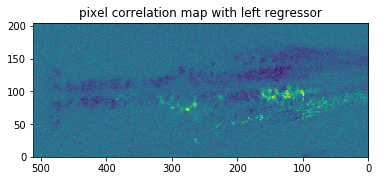

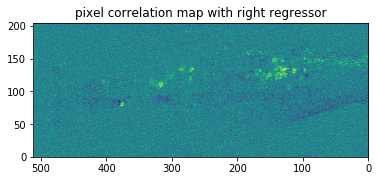

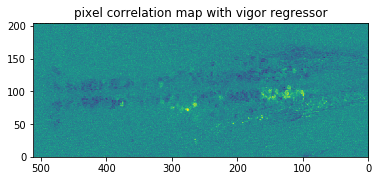

In [33]:
# quick view
plt.imshow(cmap_lp)
plt.title('pixel correlation map with left regressor')
plt.xlim(imarray.shape[1], 0)
plt.ylim(0, imarray.shape[0])
plt.savefig(output_path+'fig/'+fishlabel+ '_ERC/' +plane+'/pixel_cmap_left_reg.png')
plt.figure()
plt.imshow(cmap_rp)
plt.title('pixel correlation map with right regressor')
plt.xlim(imarray.shape[1], 0)
plt.ylim(0, imarray.shape[0])
plt.savefig(output_path+'fig/'+fishlabel+ '_ERC/' +plane+'/pixel_cmap_right_reg.png')
plt.figure()
plt.imshow(cmap_vp)
plt.title('pixel correlation map with vigor regressor')
plt.xlim(imarray.shape[1], 0)
plt.ylim(0, imarray.shape[0])
plt.savefig(output_path+'fig/'+fishlabel+ '_ERC/' +plane+'/pixel_cmap_vigor_reg.png')


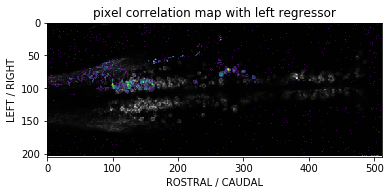

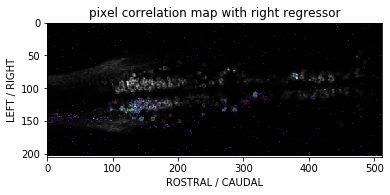

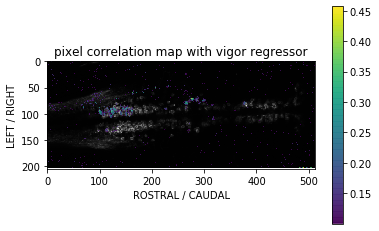

In [45]:
# quick view
left=cmap_lp.copy()
left[np.where(left < 0.1)] = np.nan
plt.imshow(ops['meanImg'], cmap='Greys_r')
plt.imshow(left, alpha=0.8)
plt.title('pixel correlation map with left regressor')
plt.ylabel('LEFT / RIGHT')
plt.xlabel('ROSTRAL / CAUDAL')
plt.xlim(0, imarray.shape[1])
plt.ylim(imarray.shape[0], 0)
plt.savefig(output_path+'fig/'+fishlabel+'/'+plane+'/cmap_left_mask.png', )
plt.figure()
right = cmap_rp.copy()
right[np.where(right < 0.1)] = np.nan
plt.imshow(ops['meanImg'], cmap='Greys_r')
plt.imshow(right, alpha=0.8)
plt.title('pixel correlation map with right regressor')
plt.ylabel('LEFT / RIGHT')
plt.xlabel('ROSTRAL / CAUDAL')
plt.xlim(0, imarray.shape[1])
plt.ylim(imarray.shape[0], 0)
plt.savefig(output_path+'fig/'+fishlabel+'/'+plane+'/cmap_right_mask.png')
plt.figure()
vigor = cmap_vp.copy()
vigor[np.where(vigor < 0.1)] = np.nan
plt.imshow(ops['meanImg'], cmap='Greys_r')
plt.imshow(vigor, alpha=0.8)
plt.colorbar()
plt.title('pixel correlation map with vigor regressor')
plt.ylabel('LEFT / RIGHT')
plt.xlabel('ROSTRAL / CAUDAL')
plt.xlim(0, imarray.shape[1])
plt.ylim(imarray.shape[0], 0)
plt.savefig(output_path+'fig/'+fishlabel+'/'+plane+'/cmap_vig_mask.png')

In [46]:
# save the masks
left2 = left.copy()
left2 = left2 * 255
left_mask = left2.astype(np.uint16)
png.from_array(left_mask, mode="L").save(output_path+'fig/'+fishlabel+'/'+plane+'/left_reg_mask.png')

right2 = right.copy()
right2 = right2 * 255
right_mask = right2.astype(np.uint16)
png.from_array(right_mask, mode="L").save(output_path+'fig/'+fishlabel+'/'+plane+'/right_reg_mask.png')

vig2 = vigor.copy()
vig2 = vig2 * 255
vig_mask = vig2.astype(np.uint16)
png.from_array(vig_mask, mode="L").save(output_path+'fig/'+fishlabel+'/'+plane+'/vig_reg_mask.png')